# Mechanics Package tutorials

## Kinematics and Workspace of a 2-Link Planar Manipulator Using Python

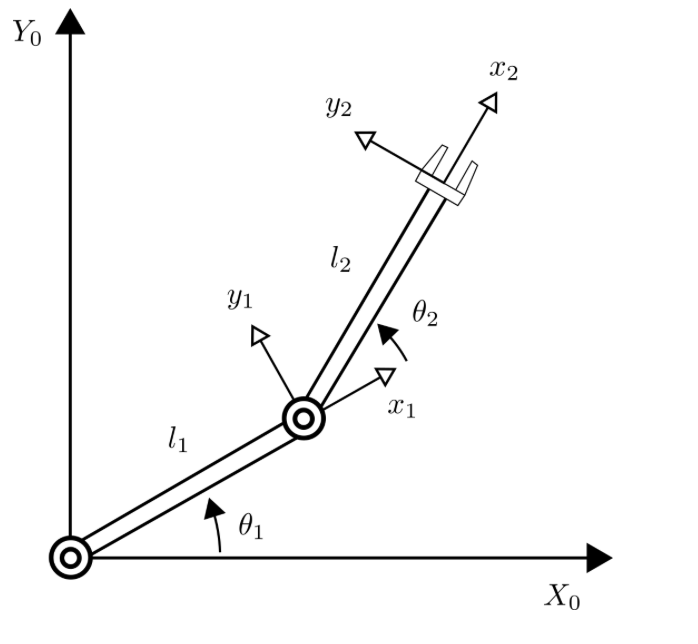

In [11]:
from IPython.display import Image, display
display(Image(filename="images/2LinkPlanarManipulator.png"))

In the following cells, we will import additional modules and functions as needed for symbolic computation and kinematic analysis, such as `dynamicsymbols`, `Point`, and `ReferenceFrame` from `sympy.physics.mechanics`. 

These imports will enable us to define symbolic variables, reference frames, and points required for modeling the 2-link planar manipulator.

In [2]:
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, Point, ReferenceFrame

Now, we declare the symbols for the link lengths ($l_1$, $l_2$) and joint variables ($\theta_1$, $\theta_2$) which will be used for further formulation.

In [3]:
l1, l2 = symbols('l1 l2')
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1, theta2, l1, l2 

(theta1(t), theta2(t), l1, l2)

**symbols vs dynamicsymbols**

| Feature     | `symbols()`                                                            | `dynamicsymbols()`                                                             |
| ----------- | ---------------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| Purpose     | Create **static symbols** (e.g. link lengths, constants, fixed angles) | Create **time-dependent functions** (e.g. joint angles, positions, velocities) |
| Derivatives | Returns 0 for time derivatives                                         | Handles symbolic derivatives with respect to time                              |
| Type        | `sympy.Symbol`                                                         | `sympy.Function` subclass                                                      |
| Use Case    | Constants: $l_1, m, g, \theta_0$                                       | Generalized coordinates: $\theta(t), x(t), q(t)$                               |


### Kinematics using Sympy Mechanics

In the first step, we define the kinematic relationships among the rigid bodies of the 2-link manipulator shown above. We use Sympy's `ReferenceFrame` objects to describe the four frames, define their orientations, and construct vectors within these frames to locate key points. Our objective is to analytically calculate the tip position in the XY (Cartesian) space.

#### Reference Frames Assigment

These reference frames hold the information that defines how each frame is translted and/or oriented relative to each other. We start by creating four reference frames for each frame in the system.

In [4]:
base_frame = ReferenceFrame('B')
shoulder_frame = ReferenceFrame('S')
elbow_frame = ReferenceFrame('E')
hand_frame = ReferenceFrame('H')

#### Frame Orientation Definition

Next, we specify how each reference frame is oriented relative to the others. The two generalized coordinates, $\theta_1(t)$ and $\theta_2(t)$, represent the time-varying joint angles at the shoulder and elbow, respectively. The rigid links, with lengths $l_1$ and $l_2$, maintain fixed distances between the joints.

The shoulder frame is then oriented by an angle $\theta_1$ about the base frame's z-axis. Subsequently, the elbow frame is oriented by an angle $\theta_2$ about the shoulder frame's z-axis, and so on, following the physical structure of the 2-link planar manipulator.

In [9]:
shoulder_frame.orient(base_frame, 'Axis', [theta1, base_frame.z])
elbow_frame.orient(shoulder_frame, 'Axis', [theta2, shoulder_frame.z])
hand_frame.orient(elbow_frame, 'Axis', [0, elbow_frame.z])

The `orient` function in Sympy Mechanics is used to define the relative orientation between two reference frames. In the previous code, we used `orient` to specify how each frame (shoulder, elbow, hand) is rotated with respect to its parent frame:

- `shoulder_frame.orient(base_frame, 'Axis', [theta1, base_frame.z])` rotates the shoulder frame by angle $\theta_1$ about the base frame's z-axis.
- `elbow_frame.orient(shoulder_frame, 'Axis', [theta2, shoulder_frame.z])` rotates the elbow frame by angle $\theta_2$ about the shoulder frame's z-axis.
- `hand_frame.orient(elbow_frame, 'Axis', [0, elbow_frame.z])` keeps the hand frame aligned with the elbow frame.

This approach allows us to model the kinematic chain of the manipulator by chaining these rotations, reflecting the physical joint angles of the robot.

#### Forward Kinematics

To obtain the transformation matrix from the base frame to the hand frame, we use Sympy's `dcm()` (direction cosine matrix) method. This method computes the rotation matrix that describes the orientation of the hand frame relative to the base frame.

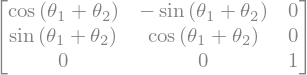

In [12]:
T02 = base_frame.dcm(hand_frame)
T02.simplify()

#### Rigid Body Points and Locations

To derive the forward kinematic equations, we need to define the length of each rigid body. We will first define points that locate the joints: base, shoulder, elbow, and hand.

In [13]:
base = Point('O')
shoulder = Point('0')
elbow = Point('1')
hand = Point('2')

Next, we set the positions of each joint using the `Point.set_pos()` method. This method specifies the location of a point relative to a reference point and a displacement vector, allowing us to define the spatial relationships between the base, shoulder, elbow, and hand.

In [14]:
shoulder.set_pos(base, 0 * base_frame.x)
elbow.set_pos(shoulder, l1 * shoulder_frame.x)
hand.set_pos(elbow, l2 * elbow_frame.x)

**Base to Hand Position**

The following commands calculate the position vector of the hand (end-effector) relative to the base frame. First, the vector from the base to the hand is computed and expressed in the base frame. Then, the x and y components of this position vector are extracted, representing the Cartesian coordinates of the manipulator's tip as functions of the joint angles and link lengths.

In [15]:
pxy = (hand.pos_from(base).express(base_frame)).simplify()
pxy

In [17]:
# Extract the x and y components of the vector pxy in the base_frame
px, py = pxy.dot(base_frame.x), pxy.dot(base_frame.y)
px, py

### Tip Position Evaluation

To numerically evaluate the tip (end-effector) position of the manipulator, we use Sympy's `lambdify` function. This function converts the symbolic expressions for $p_x$ and $p_y$ into efficient numerical functions that accept $l_1$, $l_2$, $\theta_1$, and $\theta_2$ as input arguments. This allows us to compute the tip position for any given set of link lengths and joint angles, enabling visualization and further analysis.

In [19]:
fx = lambdify((l1, l2, theta1, theta2), px, 'numpy')
fy = lambdify((l1, l2, theta1, theta2), py, 'numpy')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

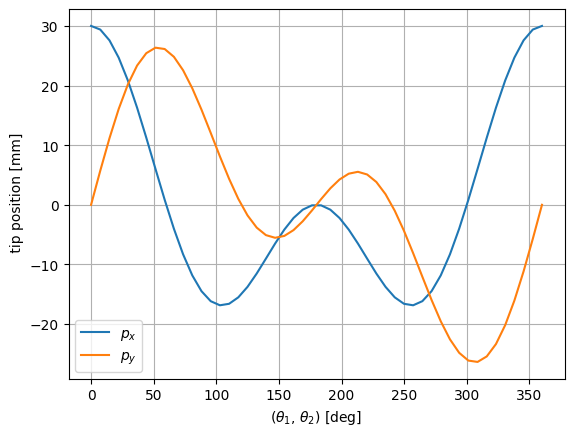

In [ ]:
theta1s = np.linspace(np.deg2rad(0), np.deg2rad(360)) # desired range of motion for joint 1
theta2s = np.linspace(np.deg2rad(0), np.deg2rad(360)) # desired range of motion for joint 2

zx = np.array(fx(15.0, 15.0, theta1s, theta2s))
zy = np.array(fy(15.0, 15.0, theta1s, theta2s))
 
fig, ax1 = plt.subplots()
ax1.plot(np.rad2deg(theta1s), zx, label = r'$p_x$')
ax1.plot(np.rad2deg(theta1s), zy, label = r'$p_y$')
ax1.set_xlabel(r'($\theta_1$, $\theta_2$) [deg]')
ax1.set_ylabel(r' tip position [mm]')
plt.legend()
plt.grid()